# Which nursing homes have lower staffing levels?

## Objective

- To help Clipboard Health target their sales efforts towards facilities with staffing challenges.


## Methodology

- Identify Understaffed Facilities (Calculate Staffing Levels)
- Identify Understaffed Facilities
- Analyze and Target

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


# Load the cleaned PBJ dataset
df_cleaned = pd.read_csv('C:/Users/hp/Downloads/Cleaned_PBJ_Daily_Nurse_Staffing_Q1_2024.csv')

# Load the cleaned sn dataset
df_sn_cleaned = pd.read_csv(
    'C:/Users/hp/Downloads/Cleaned_Skilled_Nursing_Facility_Quality_Reporting_Program_Provider_Data_Aug2024.csv'
)


C:\Users\hp\AppData\Local\Temp\ipykernel_248\489281095.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('C:/Users/hp/Downloads/Cleaned_PBJ_Daily_Nurse_Staffing_Q1_2024.csv')
C:\Users\hp\AppData\Local\Temp\ipykernel_248\489281095.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sn_cleaned = pd.read_csv(


### Calculate Staffing Levels

- Determine the total hours worked by both full-time staff and contractors for each facility using df_cleaned.

In [2]:
# Calculate total staffing hours (including employees and contractors)
df_cleaned['Total_Staffing_Hours'] = (
    df_cleaned['Hrs_RN'] + df_cleaned['Hrs_LPN'] + df_cleaned['Hrs_CNA'] +
    df_cleaned['Hrs_RNDON'] + df_cleaned['Hrs_RNadmin'] + 
    df_cleaned['Hrs_LPNadmin'] + df_cleaned['Hrs_NAtrn'] + 
    df_cleaned['Hrs_MedAide']
)

# Calculate total contractor hours
df_cleaned['Total_Contractor_Hours'] = (
    df_cleaned['Hrs_RN_ctr'] + df_cleaned['Hrs_LPN_ctr'] + df_cleaned['Hrs_CNA_ctr'] +
    df_cleaned['Hrs_RNDON_ctr'] + df_cleaned['Hrs_RNadmin_ctr'] + 
    df_cleaned['Hrs_LPNadmin_ctr'] + df_cleaned['Hrs_NAtrn_ctr'] + 
    df_cleaned['Hrs_MedAide_ctr']
)

In [3]:
# Calculate total nurse staffing hours per resident
df_cleaned['Staffing_Per_Resident'] = df_cleaned['Total_Staffing_Hours'] / df_cleaned['MDScensus']

# Calculate the national average staffing hours per resident
national_avg_staffing = df_cleaned['Staffing_Per_Resident'].mean()

# Flad facilities that fall below the national average
df_cleaned['Understaffed'] = df_cleaned['Staffing_Per_Resident'] < national_avg_staffing

### Identify Understaffed Facilities

In [5]:
# Benchmark for understaffed nursing homes (CMS recommendation: 4.1 hours per resident per day)
benchmark_staffing_hours = 4.1

# Flag nursing homes as understaffed if they fall below the benchmark
df_cleaned['Understaffed'] = df_cleaned['Staffing_Per_Resident'] < benchmark_staffing_hours

# View the updated DataFrame with the understaffed flag
df_cleaned[['PROVNUM', 'Total_Staffing_Hours', 'Staffing_Per_Resident', 'Understaffed']].head()

# Calculate total staffing hours as a percentage of a benchmark

df_cleaned['Staffing_Hours_Percentage'] = (df_cleaned['Staffing_Per_Resident'] / benchmark_staffing_hours) * 100

### Merge Datasets 

In [13]:
# Subset the DataFrames
df_cleaned_subset = df_cleaned[['PROVNUM', 'CITY', 'STATE', 'Understaffed', 'Total_Staffing_Hours', 'Staffing_Per_Resident']]
df_sn_cleaned_subset = df_sn_cleaned[['PROVNUM', 'Provider Name', 'Score', 'City/Town', 'State']]

# Merge in chunks
merged_chunks = []
chunk_size = 10000  # Adjust based on memory constraints

for i in range(0, len(df_cleaned_subset), chunk_size):
    chunk_cleaned = df_cleaned_subset.iloc[i:i + chunk_size]
    merged_chunk = pd.merge(chunk_cleaned, df_sn_cleaned_subset, on='PROVNUM', how='inner')
    merged_chunks.append(merged_chunk)

# Concatenate the merged chunks into one DataFrame
merged_df = pd.concat(merged_chunks, ignore_index=True)

In [14]:
# Identify understaffed facilities 
understaffed_facilities = merged_df[merged_df['Understaffed'] == True]


### Analyze and Target

In [15]:
# Filter to understaffed facilities with low Score (i.e, Score <= 2)
filtered_facilities = merged_df[(merged_df['Understaffed'] == True) & (merged_df['Score'] <= 2)]

# View the facilities that are understaffed and have a low quality rating
filtered_facilities[['PROVNUM', 'Provider Name', 'Total_Staffing_Hours', 'Staffing_Per_Resident', 'Score', 'Understaffed']].head()

,PROVNUM,Provider Name,Total_Staffing_Hours,Staffing_Per_Resident,Score,Understaffed
18,015413,LIGHTHOUSE REHABILITATION & HEALTHCARE CENTER,203.77,4.0754,1.21,True
23,015413,LIGHTHOUSE REHABILITATION & HEALTHCARE CENTER,203.77,4.0754,1.00,True
38,015413,LIGHTHOUSE REHABILITATION & HEALTHCARE CENTER,203.77,4.0754,0.00,True
39,015413,LIGHTHOUSE REHABILITATION & HEALTHCARE CENTER,203.77,4.0754,0.00,True
40,015413,LIGHTHOUSE REHABILITATION & HEALTHCARE CENTER,203.77,4.0754,0.00,True


In [16]:
# Group the filtered facilities by state to identify areas of concentrated understaffing
understaffed_by_state = filtered_facilities.groupby('STATE').size().reset_index(name='Understaffed_Facilities')

# Sort states by the number of understaffed facilities in descending order
understaffed_by_state = understaffed_by_state.sort_values(by='Understaffed_Facilities', ascending=False)

# View the states with the most understaffed facilities
print(understaffed_by_state.head())

   STATE  Understaffed_Facilities
41    TX                   332645
9     FL                   215196
32    OH                   169458
4     CA                   125252
20    MI                   121404


In [17]:
# Sort facilities by the severity of understaffing
sorted_understaffed_facilities = understaffed_facilities.sort_values(by='Staffing_Per_Resident', ascending=True)

# Display the top 10 facilities with the lowest staffing levels
sorted_understaffed_facilities[['PROVNUM', 'Provider Name', 'CITY', 'STATE', 'Staffing_Per_Resident']].head(10)

         PROVNUM                 Provider Name      CITY STATE  \
26221257  315471         ST CATHERINE OF SIENA  CALDWELL    NJ   
35893553  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893552  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893551  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893550  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893549  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893548  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893547  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893546  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   
35893545  445470  TOWNE SQUARE CARE OF PURYEAR   PURYEAR    TN   

          Staffing_Per_Resident  
26221257                    0.0  
35893553                    0.0  
35893552                    0.0  
35893551                    0.0  
35893550                    0.0  
35893549                    0.0  
35893548                    0.0  
3

### Visualization
- Bar plot showing the number of understaffed facilities in each state

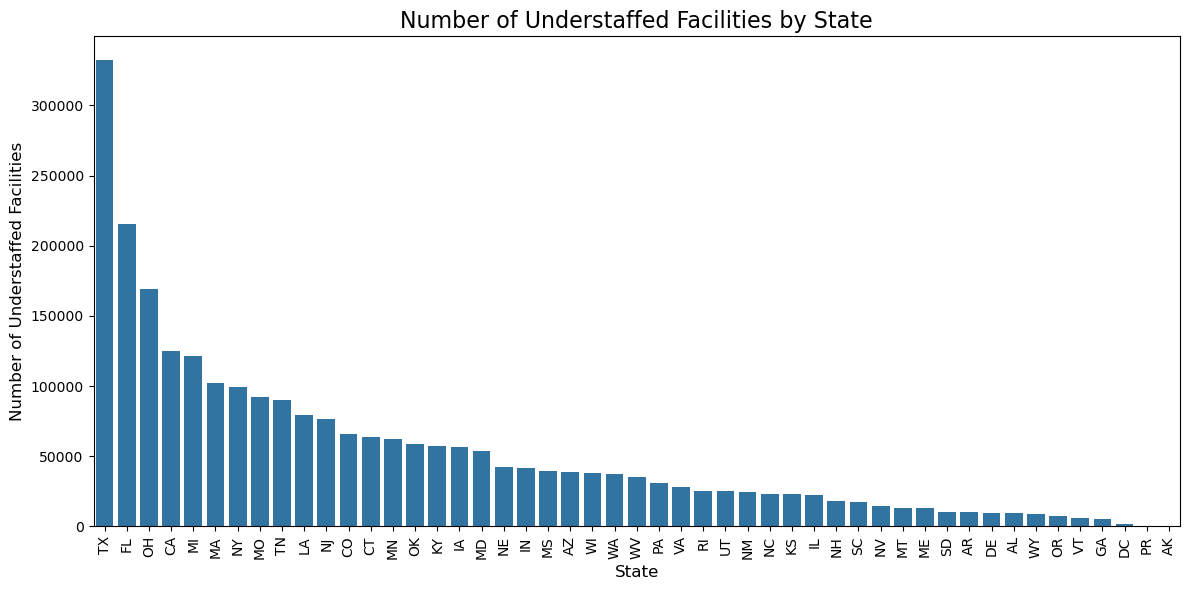

In [19]:
# Set up the plotting environment
plt.figure(figsize=(12, 6))
sns.barplot(data=understaffed_by_state, x='STATE', y='Understaffed_Facilities')

# Add labels and title
plt.title('Number of Understaffed Facilities by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Understaffed Facilities', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


- Scatter plot of facilities based on staffing levels and quality scores

C:\Users\hp\AppData\Local\Temp\ipykernel_248\489599843.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=filtered_facilities,


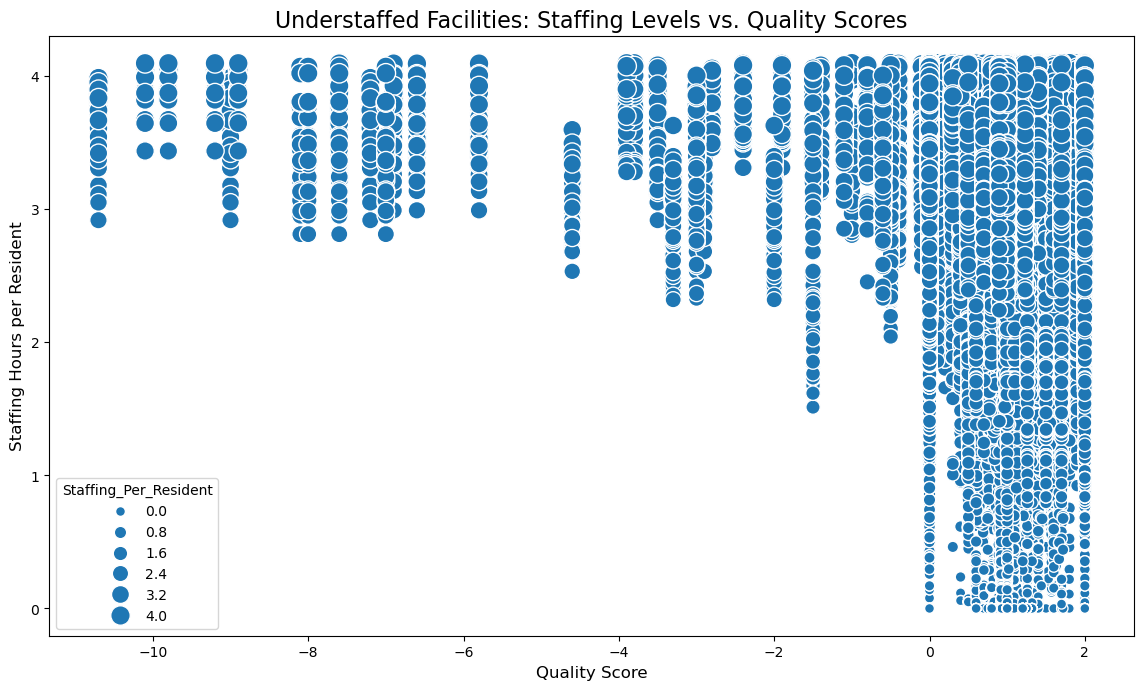

In [25]:
# Scatter plot without hue to reduce the number of colors
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_facilities, 
                x='Score', 
                y='Staffing_Per_Resident', 
                size='Staffing_Per_Resident', 
                sizes=(50, 200))  # Single color palette for consistency

# Add labels and title
plt.title('Understaffed Facilities: Staffing Levels vs. Quality Scores', fontsize=16)
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Staffing Hours per Resident', fontsize=12)

plt.subplots_adjust(bottom=0.15, top=0.9)
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_248\357604730.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_facilities, x='Score', y='Staffing_Per_Resident', palette='viridis')


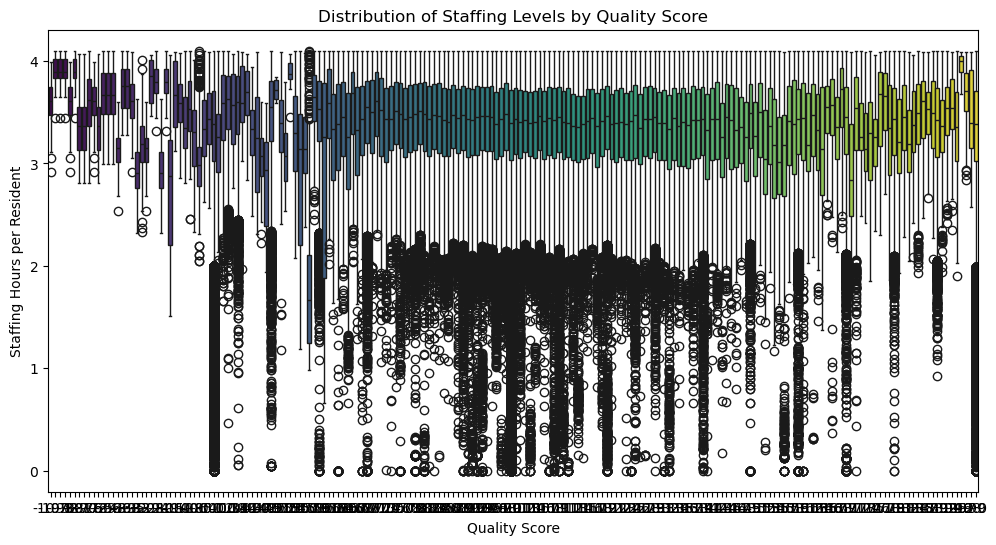

In [27]:
# Box plot showing distribution of staffing per resident across different score ranges
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_facilities, x='Score', y='Staffing_Per_Resident', palette='viridis')

plt.title('Distribution of Staffing Levels by Quality Score')
plt.xlabel('Quality Score')
plt.ylabel('Staffing Hours per Resident')
plt.show()


### Full Code

In [ ]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


# Load the cleaned PBJ dataset
df_cleaned = pd.read_csv('C:/Users/hp/Downloads/Cleaned_PBJ_Daily_Nurse_Staffing_Q1_2024.csv')

# Load the cleaned sn dataset
df_sn_cleaned = pd.read_csv(
    'C:/Users/hp/Downloads/Cleaned_Skilled_Nursing_Facility_Quality_Reporting_Program_Provider_Data_Aug2024.csv'
)


# Calculate total staffing hours (including employees and contractors)
df_cleaned['Total_Staffing_Hours'] = (
    df_cleaned['Hrs_RN'] + df_cleaned['Hrs_LPN'] + df_cleaned['Hrs_CNA'] +
    df_cleaned['Hrs_RNDON'] + df_cleaned['Hrs_RNadmin'] + 
    df_cleaned['Hrs_LPNadmin'] + df_cleaned['Hrs_NAtrn'] + 
    df_cleaned['Hrs_MedAide']
)

# Calculate total contractor hours
df_cleaned['Total_Contractor_Hours'] = (
    df_cleaned['Hrs_RN_ctr'] + df_cleaned['Hrs_LPN_ctr'] + df_cleaned['Hrs_CNA_ctr'] +
    df_cleaned['Hrs_RNDON_ctr'] + df_cleaned['Hrs_RNadmin_ctr'] + 
    df_cleaned['Hrs_LPNadmin_ctr'] + df_cleaned['Hrs_NAtrn_ctr'] + 
    df_cleaned['Hrs_MedAide_ctr']
)

# Calculate total nurse staffing hours per resident
df_cleaned['Staffing_Per_Resident'] = df_cleaned['Total_Staffing_Hours'] / df_cleaned['MDScensus']

# Calculate the national average staffing hours per resident
national_avg_staffing = df_cleaned['Staffing_Per_Resident'].mean()

# Flag facilities that fall below the national average
df_cleaned['Understaffed'] = df_cleaned['Staffing_Per_Resident'] < national_avg_staffing

# Benchmark for understaffed nursing homes (CMS recommendation: 4.1 hours per resident per day)
benchmark_staffing_hours = 4.1

# Flag nursing homes as understaffed if they fall below the benchmark
df_cleaned['Understaffed'] = df_cleaned['Staffing_Per_Resident'] < benchmark_staffing_hours

# View the updated DataFrame with the understaffed flag
df_cleaned[['PROVNUM', 'Total_Staffing_Hours', 'Staffing_Per_Resident', 'Understaffed']].head()

# Calculate total staffing hours as a percentage of a benchmark

df_cleaned['Staffing_Hours_Percentage'] = (df_cleaned['Staffing_Per_Resident'] / benchmark_staffing_hours) * 100

# Subset the DataFrames
df_cleaned_subset = df_cleaned[['PROVNUM', 'CITY', 'STATE', 'Understaffed', 'Total_Staffing_Hours', 'Staffing_Per_Resident']]
df_sn_cleaned_subset = df_sn_cleaned[['PROVNUM', 'Provider Name', 'Score', 'City/Town', 'State']]

# Merge in chunks
merged_chunks = []
chunk_size = 10000  # Adjust based on memory constraints

for i in range(0, len(df_cleaned_subset), chunk_size):
    chunk_cleaned = df_cleaned_subset.iloc[i:i + chunk_size]
    merged_chunk = pd.merge(chunk_cleaned, df_sn_cleaned_subset, on='PROVNUM', how='inner')
    merged_chunks.append(merged_chunk)

# Concatenate the merged chunks into one DataFrame
merged_df = pd.concat(merged_chunks, ignore_index=True)

# Identify understaffed facilities 
understaffed_facilities = merged_df[merged_df['Understaffed'] == True]


# Filter to understaffed facilities with low Score (i.e, Score <= 2)
filtered_facilities = merged_df[(merged_df['Understaffed'] == True) & (merged_df['Score'] <= 2)]

# View the facilities that are understaffed and have a low quality rating
filtered_facilities[['PROVNUM', 'Provider Name', 'Total_Staffing_Hours', 'Staffing_Per_Resident', 'Score', 'Understaffed']].head()

# Group the filtered facilities by state to identify areas of concentrated understaffing
understaffed_by_state = filtered_facilities.groupby('STATE').size().reset_index(name='Understaffed_Facilities')

# Sort states by the number of understaffed facilities in descending order
understaffed_by_state = understaffed_by_state.sort_values(by='Understaffed_Facilities', ascending=False)

# View the states with the most understaffed facilities
print(understaffed_by_state.head())

# Sort facilities by the severity of understaffing
sorted_understaffed_facilities = understaffed_facilities.sort_values(by='Staffing_Per_Resident', ascending=True)

# Display the top 10 facilities with the lowest staffing levels
sorted_understaffed_facilities[['PROVNUM', 'Provider Name', 'CITY', 'STATE', 'Staffing_Per_Resident']].head(10)

# Set up the plotting environment
plt.figure(figsize=(12, 6))
sns.barplot(data=understaffed_by_state, x='STATE', y='Understaffed_Facilities')

# Add labels and title
plt.title('Number of Understaffed Facilities by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Understaffed Facilities', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

